In [30]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
import PIL
from PIL import Image
import tensorflow as tf
import pandas as pd
import glob
import datetime

from utils import TrainingSetManager
from utils import TeenmagiDataset

import time

import random
from random import shuffle
import math

import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import initializers
from keras import backend as K

from os import walk
import pickle
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier

from tempfile import TemporaryFile

from IPython.display import clear_output
from tqdm.notebook import tqdm

In [31]:
#training_set_manager = TrainingSetManager()
#print(len(training_set_manager.validation_x))

In [32]:
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

# Data augmented layers

In [38]:
# Create a `Sequential` model and add a NoisyDense
# layer as the first layer.
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(8,8,1)))
model.add(tfa.layers.NoisyDense(32))
# Now the model will take as input arrays of shape (None, 16)
# and output arrays of shape (None, 32).
# Note that after the first layer, you don't need to specify
# the size of the input anymore:
model.add(tfa.layers.NoisyDense(1))
model.output_shape


(None, 8, 8, 1)

# 

# Image denoising

In [17]:
#(denoiser_training, denoser_valid, denoiser_test) =\
#    training_set_manager.gen_training_set(denoiser=True, category_sizes=2000, n_augmentation=500)

teenmagi_dataset = TeenmagiDataset(denoiser=True, batch_size=64, n_valid=100)

In [16]:
x = teenmagi_dataset[0]

In [30]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    samplewise_center=True,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0,
    dtype=None
)

In [22]:
datagen.fit(denoiser_training[0])

In [35]:
images = datagen.flow(denoiser_training[0], denoiser_training[1], batch_size=32)

In [18]:
def CropPad(x):
    if np.random.rand() <= 0.1:
        c = np.random.randint(1,3)
        if np.random.rand() <= 0.5:
            x = tf.keras.layers.Cropping2D(cropping=((c, c), (0, 0)))(x)
            x = tf.keras.layers.ZeroPadding2D(padding=((c, c), (0, 0)))(x)
        else:
            x = tf.keras.layers.Cropping2D(cropping=((0, 0), (c, c)))(x)
            x = tf.keras.layers.ZeroPadding2D(padding=((0, 0), (c, c)))(x)
    return x

class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.data_augmentation = tf.keras.Sequential(
          [
            layers.RandomFlip("horizontal"),
            layers.RandomFlip("vertical"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.1),
            layers.Lambda(CropPad)
          ]
        )
        
        self.encoder = tf.keras.Sequential([
          layers.Input(shape=(8, 8, 1)),
          layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
          layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

        self.decoder = tf.keras.Sequential([
          layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

    def call(self, x):
        augmentation = self.data_augmentation(x)
        encoded = self.encoder(augmentation)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Denoise()

if False:
    try:
        #autoencoder = tf.keras.models.load_model('autoencoder')
        print("Model loaded")
    except:
        pass

autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=['mae'])

In [19]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau( monitor='loss', 
                                                  factor=0.7,
                                                  patience=2, 
                                                  min_lr=1e-6, 
                                                  verbose=1,
                                                  #min_delta=0.005,
                                                  cooldown=3
                                                )

autoencoder.fit( teenmagi_dataset, #datagen.flow(denoiser_training[0], denoiser_training[1], batch_size=32), 
                #denoiser_training[0], denoiser_training[1],
                epochs=10,
                shuffle=True,
                callbacks=[
                    reduce_lr
                ],
               )

Epoch 1/10
10000/10000 [==============================] - 96s 9ms/step - loss: 0.0258 - mae: 0.1230 - lr: 0.0010
Epoch 2/10
 8256/10000 [=======================>......] - ETA: 18s - loss: 0.0247 - mae: 0.1201

KeyboardInterrupt: 

In [9]:
#autoencoder.save('autoencoder_augmentation_1')

root_folder = "models/correlation_1"
model_paths = glob.glob(root_folder + "/*[val]")
print(model_paths)

['models/correlation_1\\correlation_1_val']


1
N 1


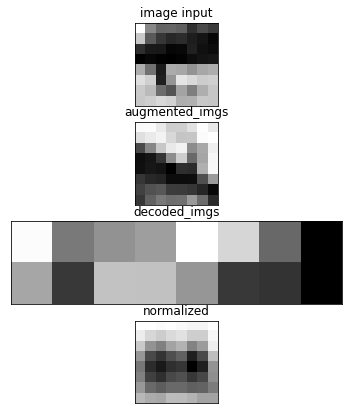

In [29]:
teenmagi_dataset_plot = TeenmagiDataset(denoiser=True, batch_size=1, n_valid=100)

input_x = teenmagi_dataset_plot[0]

augmented_imgs = autoencoder.data_augmentation(input_x[0]).numpy()
encoded_imgs = autoencoder.encoder(augmented_imgs).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
#decoded_imgs = autoencoder(np.array(denoiser_test_x)).numpy()

#decoded_imgs = training_set_manager.validation_x
print(len(decoded_imgs))
n = len(input_x[0])
print("N", n)
#start=10002
plt.figure(figsize=(20, 7))
rows = 4
for i in range(n):
    
    # display original + noise
    ax = plt.subplot(rows, n, i + 1)
    plt.title("image input", )
    plt.imshow(tf.squeeze(input_x[0]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
    # display reconstruction
    bx = plt.subplot(rows, n, i + n + 1)
    plt.title("augmented_imgs")
    plt.imshow(tf.squeeze(augmented_imgs[0]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
    
    # display reconstruction
    bx = plt.subplot(rows, n, i + n + n + 1)
    plt.title("decoded_imgs")
    plt.imshow(tf.squeeze(encoded_imgs[0][0]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
    
    bx = plt.subplot(rows, n, i + n + n + n + 1)
    plt.title("normalized")
    plt.imshow(tf.squeeze(decoded_imgs[0]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
    
    
plt.show()